In [558]:
import warnings
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import LogisticRegressionCV, PassiveAggressiveClassifier, RidgeClassifierCV, Perceptron, \
    SGDClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from xgboost import XGBClassifier
warnings.filterwarnings('ignore')

import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, \
    RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import ShuffleSplit, cross_validate, cross_val_score, train_test_split, GridSearchCV, \
    RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder

%matplotlib inline
import numpy as np
# np.random.seed(42)

In [559]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

datasets = [train, test]


In [560]:
label = LabelEncoder()
drop_columns = ['Cabin', 'Ticket', 'Name', 'PassengerId']

for dataset in datasets:
# Completing
    dataset['Age'].fillna(dataset['Age'].median(), inplace=True)

    dataset['Fare'].fillna(dataset['Fare'].median(), inplace=True)

    # DataFrame.mode() -> most frequent value
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace=True)

# Creating
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    dataset['Alone'] = 1
    dataset['Alone'].loc[dataset['FamilySize'] > 1] = 0
    dataset['Fare'] = pd.qcut(dataset['Fare'], 4)
    dataset['Age'] = pd.cut(dataset['Age'].astype(int), 5)

# Convert
    dataset['Sex'] = label.fit_transform(dataset['Sex'])
    dataset['Embarked'] = label.fit_transform(dataset['Embarked'])
    dataset['Age'] = label.fit_transform(dataset['Age'])
    dataset['Fare'] = label.fit_transform(dataset['Fare'])

# datasets = [pd.get_dummies(df, columns=['Sex', 'Embarked']) for df in datasets]


In [561]:
for dataset in datasets:
    dataset.drop(drop_columns, axis=1, inplace=True)
train = datasets[0]
test = datasets[1]
print(train.columns)
y = train['Survived']
X = train.drop('Survived', axis=1)


Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'FamilySize', 'Alone'],
      dtype='object')


In [562]:
algos = [
    AdaBoostClassifier(),
    BaggingClassifier(),
    ExtraTreesClassifier(),
    GradientBoostingClassifier(),
    RandomForestClassifier(),
    GaussianProcessClassifier(),
    LogisticRegressionCV(),
    PassiveAggressiveClassifier(),
    RidgeClassifierCV(),
    SGDClassifier(),
    Perceptron(),
    BernoulliNB(),
    GaussianNB(),
    KNeighborsClassifier(),
    SVC(probability=True),
    NuSVC(probability=True),
    LinearSVC(),
    DecisionTreeClassifier(),
    ExtraTreeClassifier(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    XGBClassifier()
]




{'mean_fit_time': array([0.86109858, 0.10332394, 0.7035192 , 1.1545136 , 3.35365057,
       1.90193043, 0.23118935, 1.43577991, 1.694874  , 1.31550803]), 'std_fit_time': array([0.02369048, 0.00312857, 0.01138279, 0.0407357 , 0.11673543,
       0.03843013, 0.00609333, 0.02128404, 0.05415416, 0.12024993]), 'mean_score_time': array([0.00578504, 0.00219493, 0.00398903, 0.00618429, 0.01276579,
       0.00977402, 0.00279527, 0.0083776 , 0.01037188, 0.00818548]), 'std_score_time': array([3.98063660e-04, 3.99923595e-04, 7.59953377e-07, 1.46559680e-03,
       3.98945848e-04, 3.99017391e-04, 3.93057462e-04, 4.88869664e-04,
       1.19659908e-03, 1.60489847e-03]), 'param_subsample': masked_array(data=[0.75, 0.8, 0.85, 0.95, 0.85, 0.95, 1, 0.7, 0.7, 0.8],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_n_estimators': masked_array(data=[1000, 100, 750, 1750, 1250, 1750, 500, 1500, 1

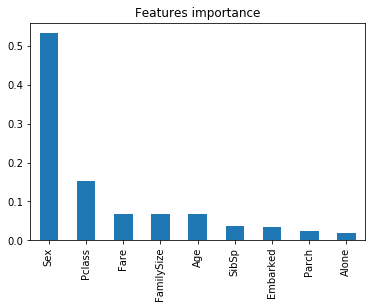

In [563]:
base_params = {
    'learning_rate':0.1,
    'n_estimators':100,
    'subsample':1,
    'criterion': 'friedman_mse',
    'min_samples_split':2,
    'min_samples_leaf':1,
    'min_weight_fraction_leaf': 0,
    'max_depth':3,
    'min_impurity_decrease': 0,
    'min_impurity_split': 1e-7,
    'max_features': None,
    'max_leaf_nodes': None,
    'n_iter_no_change': None,
}

params = {
    'criterion': 'friedman_mse',
    'min_weight_fraction_leaf': 0,
    'max_leaf_nodes': None,
    'n_iter_no_change': None,
    'random_state':0,
    'subsample': 0.75
}

params_grid = {
    'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001],
    'n_estimators':[100,250,500,750,1000,1250,1500,1750],
    'max_depth':[2,3,4,5,6,7],
    'min_samples_split':[2,4,6,8,10,20,40,60,100],
    'min_samples_leaf':[1,3,5,7,9],
    'max_features':[2,3,4,5,6,7],
    'subsample':[0.7,0.75,0.8,0.85,0.9,0.95,1]
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

nb_iterations = 1000

tuning = RandomizedSearchCV(
    estimator=GradientBoostingClassifier(**params),
    param_distributions=params_grid,
    scoring='accuracy',
    n_jobs=-1,
    n_iter=nb_iterations,
    cv=5
)

tuning.fit(X_train, y_train)
print(tuning.cv_results_, tuning.best_params_, tuning.best_score_)

model = GradientBoostingClassifier(**tuning.best_params_)
model.fit(X_train, y_train)
predictors = list(X_train)
feat_importance = pd.Series(model.feature_importances_, predictors).sort_values(ascending=False)
feat_importance.plot(kind='bar', title='Features importance')

preds = model.predict(X_test)
print(accuracy_score(preds, y_test))

model.fit(X, y)
preds = model.predict(test)


In [564]:

submission = pd.read_csv('../data/gender_submission.csv')

d = {
    'PassengerId': submission['PassengerId'],
    'Survived': preds
}

df = pd.DataFrame(data=d)
df.to_csv('../data/results.csv', index=False)

